In [1]:
import numpy as np
import pandas as pd
import re
import altair as alt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans


pd.options.display.max_columns = None
random_state = 4
np.random.seed(random_state)

In [2]:
df = pd.read_csv("ACE Mission Cleaned.csv").iloc[:, 2:]
df.head()

,proton_density,proton_temp,He4toprotons,proton_speed
0,16.655,9529.1,0.0127,323.90
1,20.601,8757.7,0.0141,322.89
2,18.679,9559.4,0.0087,324.61
3,18.481,8965.9,0.0051,322.68
4,28.315,8329.0,0.0061,321.84


In [3]:
scaled_df = StandardScaler().fit_transform(df)

In [4]:
scaled_df

array([[ 2.30767916, -1.23428816, -0.90226494, -1.39563749],
       [ 3.15140049, -1.24576392, -0.83554397, -1.40616349],
       [ 2.74044449, -1.2338374 , -1.09289625, -1.38823801],
       ...,
       [ 1.7970845 , -1.18536073,  5.21223455, -0.62202802],
       [ 2.23626433, -1.06578316,  4.14469918, -0.62296598],
       [-0.65176   , -0.87052866, -1.22157239, -0.29478381]])

In [5]:
cluster = []
calinski = []
davies = []

for k in range(2, 10):
    kmeans = KMeans(
        n_clusters=k, init="k-means++", max_iter=100, n_init=1, random_state=4
    ).fit(scaled_df)
    labels = kmeans.labels_

    cluster.append(k)
    calinski.append(metrics.calinski_harabasz_score(scaled_df, labels))
    davies.append(davies_bouldin_score(scaled_df, labels))

In [6]:
cluster_scores = pd.DataFrame(
    {"num_cluster": cluster, "calinski": calinski, "davies": davies}
)
cluster_scores

,num_cluster,calinski,davies
0,2,57797.596012,1.106740
1,3,49242.224949,1.104847
2,4,50798.331002,1.054070
3,5,47491.660015,1.094343
4,6,46585.772638,1.124053
5,7,43948.491179,1.137292
6,8,40886.714765,1.191542
7,9,41326.574760,1.162049


Text(0.5, 0.98, 'Scoring to Determine Optimal Number of Clusters \n Looking for clusters that have a low Davies-Bouldin score but a high Calinski-Harabasz score')

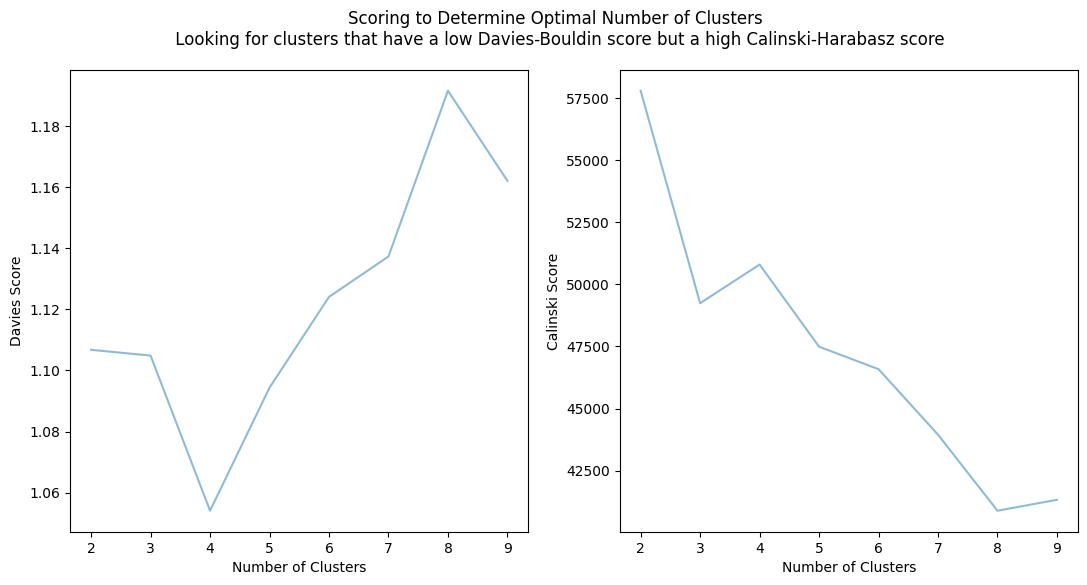

In [7]:
# create a figure to view each score for each number of clusters
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

ax1.plot(cluster_scores["num_cluster"], cluster_scores["davies"], alpha=0.5)
ax1.set_ylabel("Davies Score")
ax1.set_xlabel("Number of Clusters")

ax2.plot(cluster_scores["num_cluster"], cluster_scores["calinski"], alpha=0.5)
ax2.set_ylabel("Calinski Score")
ax2.set_xlabel("Number of Clusters")

fig.suptitle(
    "Scoring to Determine Optimal Number of Clusters \n Looking for clusters that have a low Davies-Bouldin score but a high Calinski-Harabasz score"
)

In [8]:
# Elbow Plot to Determine best number of clusters
# https://github.com/y656/Weather-data-clustering/blob/main/code%20file%20.ipynb

sum_of_squared_distances = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, init="k-means++", n_init=1)
    model = k_means.fit(scaled_df)
    sum_of_squared_distances.append(k_means.inertia_)

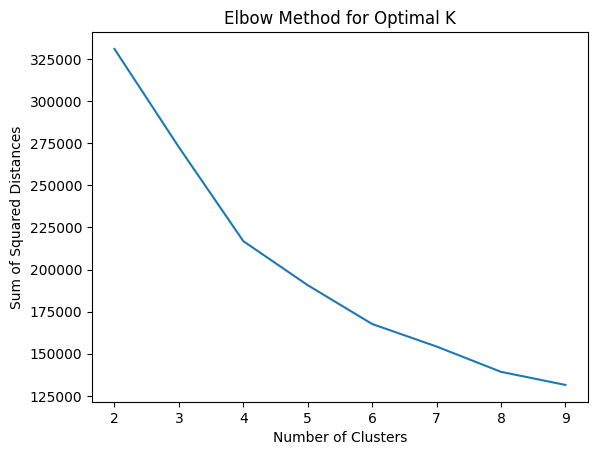

In [9]:
plt.plot(K, sum_of_squared_distances)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method for Optimal K")
plt.show()

In [10]:
optimal_k = 4  # appears to be optimal; 2 is too few and 4 is the best of the rest

kmeans = KMeans(
    n_clusters=optimal_k, init="k-means++", max_iter=100, n_init=1, random_state=4
).fit(scaled_df)

In [11]:
# https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca
# function that creates a dataframe with a column for cluster number
centers = kmeans.cluster_centers_


def pd_centers(cols_of_interest, centers):
    random_state = 4
    colNames = cols_of_interest.copy()
    colNames.append("prediction")
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P["prediction"] = P["prediction"].astype(int)
    return P


P = pd_centers(["Proton Density", "Proton Temp", "He4toproton", "Speed"], centers)
P  # these are the transformed values

,Proton Density,Proton Temp,He4toproton,Speed,prediction
0,-0.128559,-0.432876,-0.379012,-0.495972,0
1,2.564002,-0.452186,-0.166791,-0.701001,1
2,-0.423408,1.271149,-0.174936,1.323906,2
3,-0.115371,-0.493274,1.554561,-0.263480,3


In [12]:
P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Proton Density  4 non-null      float64
 1   Proton Temp     4 non-null      float64
 2   He4toproton     4 non-null      float64
 3   Speed           4 non-null      float64
 4   prediction      4 non-null      int32  
dtypes: float64(4), int32(1)
memory usage: 276.0 bytes


In [13]:
Pcenters = pd.melt(P, id_vars=["prediction"], var_name="var", value_name="val")
Pcenters["prediction"] = Pcenters["prediction"].astype(str)
fig = px.scatter(
    Pcenters,
    x="val",
    y="prediction",
    color="var",
    labels=dict(val="Value", var="Features", prediction="Predicted Cluster"),
    title="K-Means Clustering of Daily Weather Typologies",
)
fig.update_layout(
    plot_bgcolor="white",
    autosize=False,
    width=900,
    height=500,
    title={"x": 0.5, "xanchor": "center", "y": 0.875},
)
fig.update_xaxes(
    mirror=True,
    ticks="outside",
    showline=True,
    linecolor="black",
    zerolinecolor="black",
    zerolinewidth=0.25,
    gridcolor="lightgrey",
)
fig.update_yaxes(
    mirror=True,
    ticks="outside",
    showline=True,
    linecolor="black",
    zerolinecolor="black",
    gridcolor="lightgrey",
)
fig.update_traces(marker=dict(size=12))

In [14]:
kmeans.labels_
df2 = df.copy()
df2["Cluster"] = kmeans.labels_
df2["Cluster"]

0         1
1         1
2         1
3         1
4         1
         ..
121964    1
121965    3
121966    3
121967    3
121968    0
Name: Cluster, Length: 121969, dtype: int32

Text(0, 0.5, 'Speed')

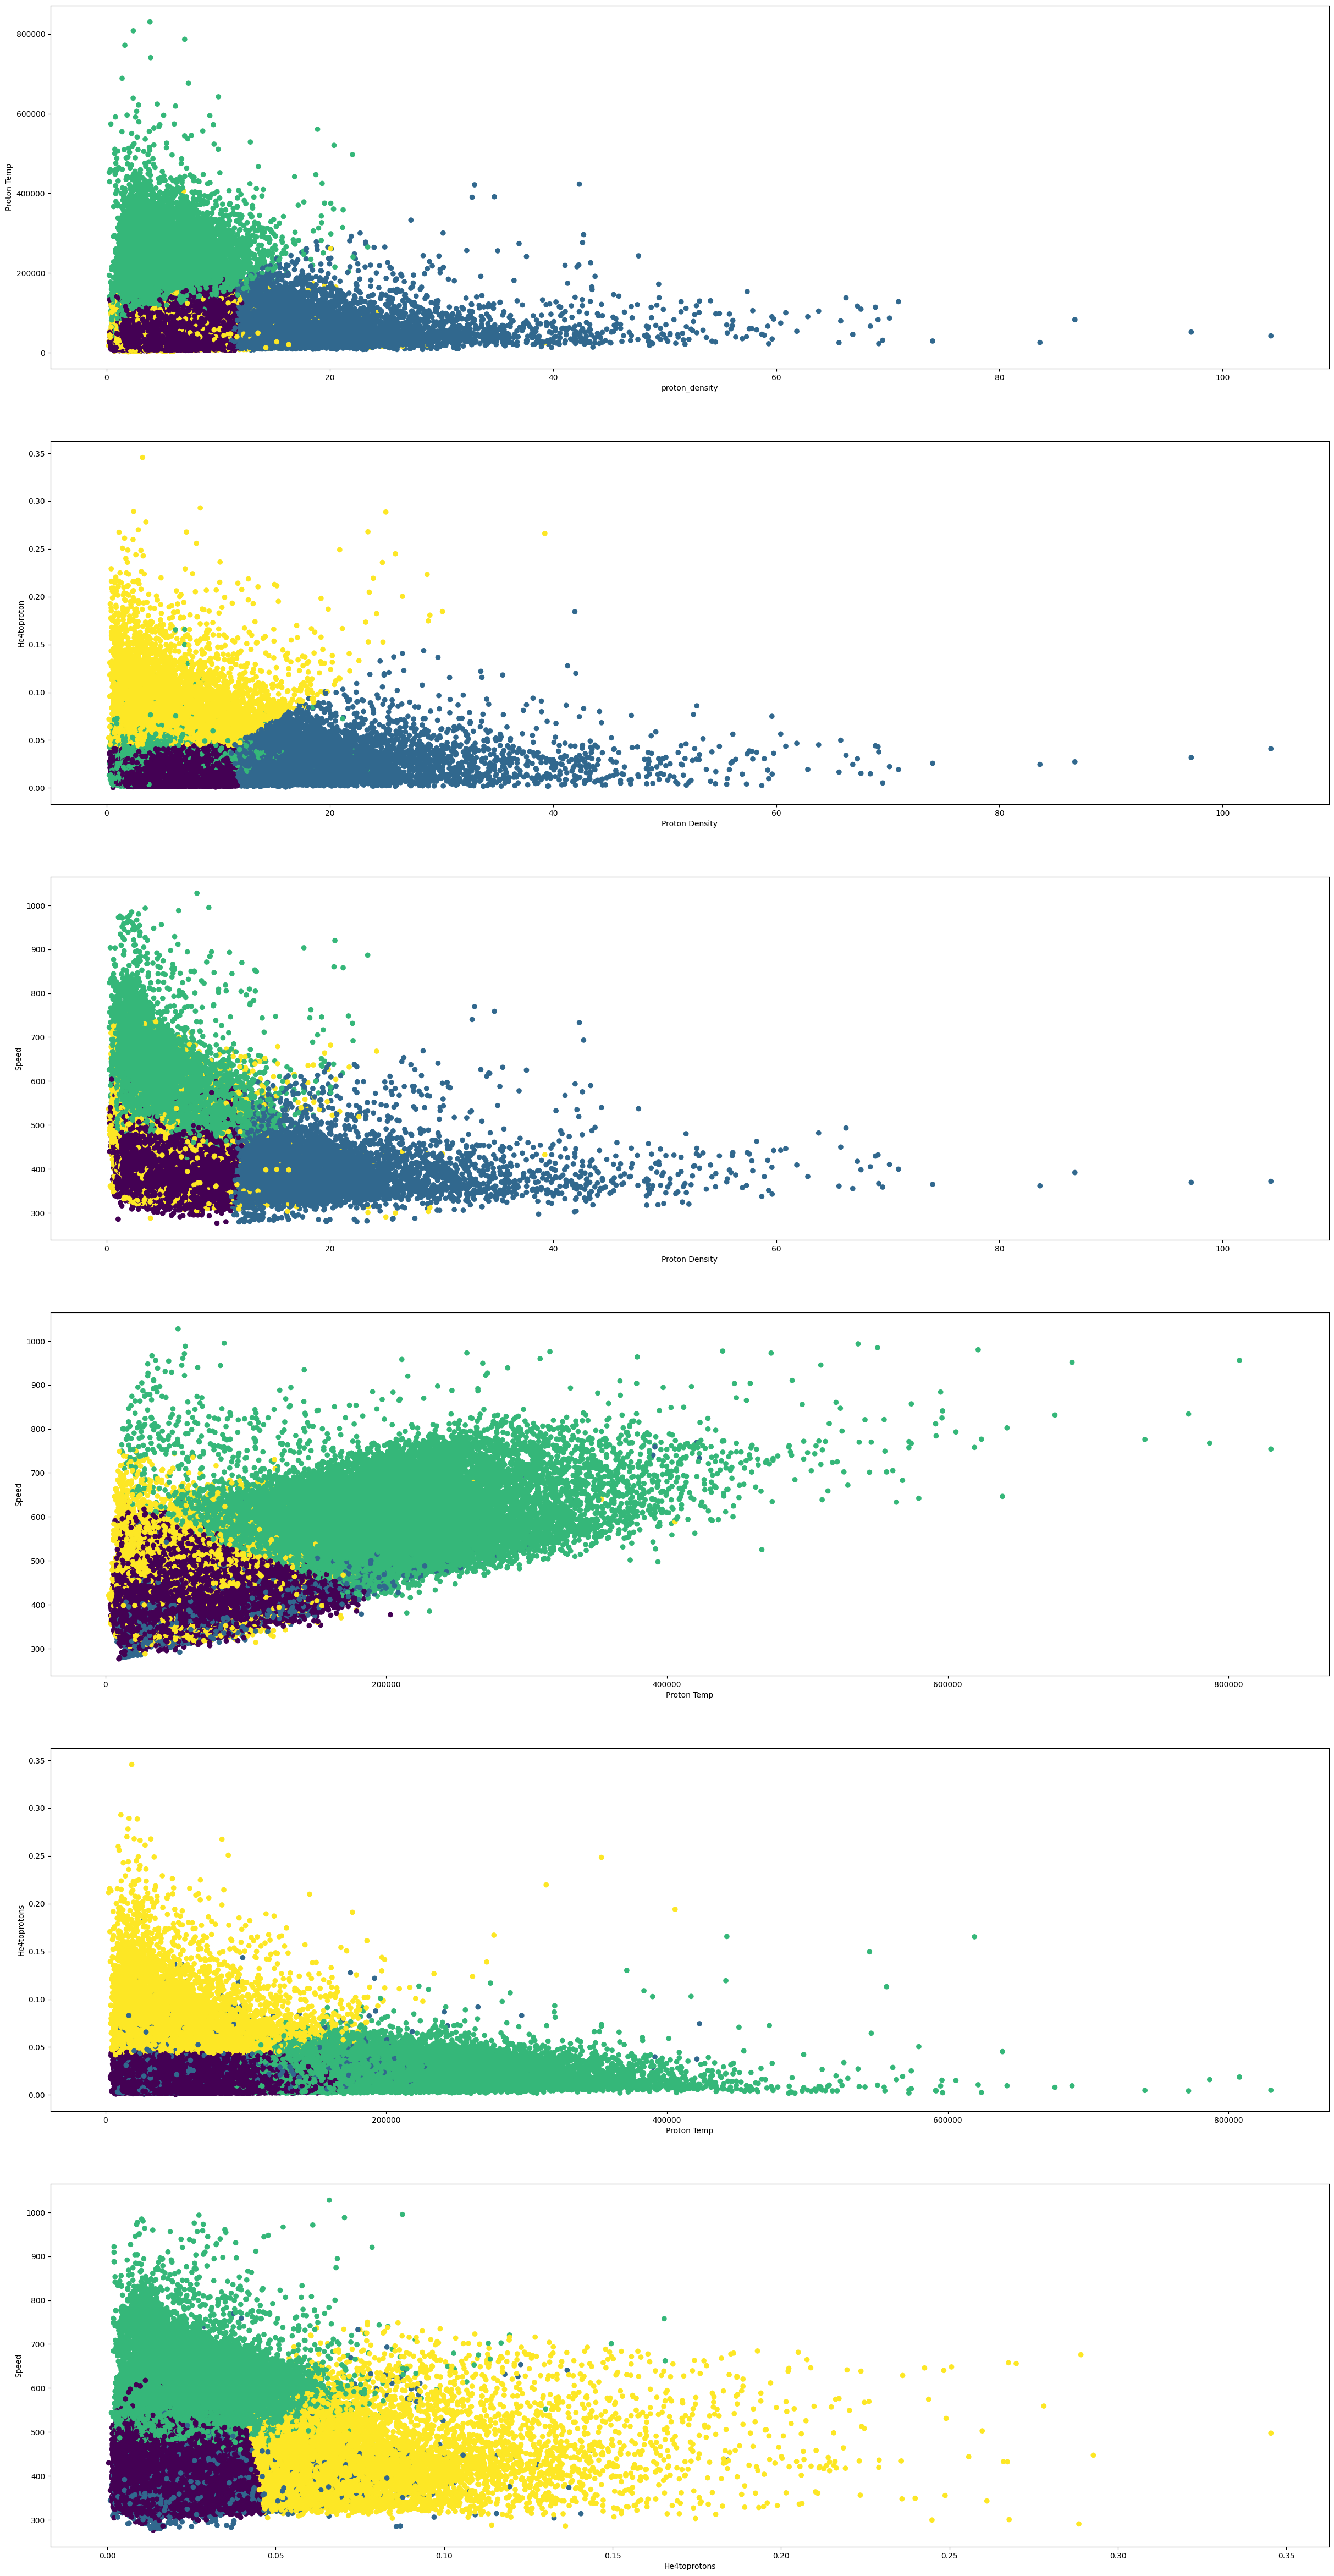

In [15]:
fig, axs = plt.subplots(6, 1, figsize=(30, 60))

axs[0].scatter(df2["proton_density"], df2["proton_temp"], c=df2["Cluster"])
axs[0].set_xlabel("proton_density")
axs[0].set_ylabel("Proton Temp")
axs[1].scatter(df2["proton_density"], df2["He4toprotons"], c=df2["Cluster"])
axs[1].set_xlabel("Proton Density")
axs[1].set_ylabel("He4toproton")
axs[2].scatter(df2["proton_density"], df2["proton_speed"], c=df2["Cluster"])
axs[2].set_xlabel("Proton Density")
axs[2].set_ylabel("Speed")
axs[3].scatter(df2["proton_temp"], df2["proton_speed"], c=df2["Cluster"])
axs[3].set_xlabel("Proton Temp")
axs[3].set_ylabel("Speed")
axs[4].scatter(df2["proton_temp"], df2["He4toprotons"], c=df2["Cluster"])
axs[4].set_xlabel("Proton Temp")
axs[4].set_ylabel("He4toprotons")
axs[5].scatter(df2["He4toprotons"], df2["proton_speed"], c=df2["Cluster"])
axs[5].set_xlabel("He4toprotons")
axs[5].set_ylabel("Speed")

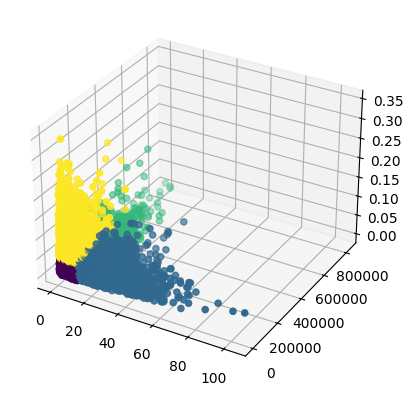

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

y = np.array(df2["proton_temp"])
z = np.array(df2["He4toprotons"])
x = np.array(df2["proton_density"])

ax.scatter(x, y, z, c=df2["Cluster"])
plt.show()

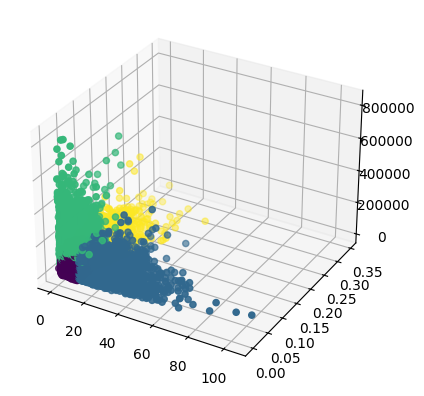

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x = np.array(df2["proton_density"])
y = np.array(df2["He4toprotons"])
z = np.array(df2["proton_temp"])

ax.scatter(x, y, z, c=df2["Cluster"])
plt.show()

In [18]:
df3 = pd.DataFrame(scaled_df, columns=df.columns.tolist())
df3["Cluster"] = k_means.labels_
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121969 entries, 0 to 121968
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   proton_density  121969 non-null  float64
 1   proton_temp     121969 non-null  float64
 2   He4toprotons    121969 non-null  float64
 3   proton_speed    121969 non-null  float64
 4   Cluster         121969 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 4.2 MB


In [19]:
def feature_importance(df: pd.DataFrame, cluster_col: str):
    features = df.columns.tolist()[:4]
    clusters = np.unique(df[cluster_col].values).tolist()
    feat = []
    cluster = []
    vars = []
    mean_diffs = []
    df_dic = {}

    for f in features:
        f_vars = []
        for c in clusters:
            df1 = df[df[cluster_col] == c]
            var1 = df1[f].var()
            f_vars.append(var1)
        feat.append(f)
        vars.append(sum(f_vars))

    df_dic["Features"] = feat
    df_dic["Total Variance"] = vars

    final_df = pd.DataFrame(df_dic)

    return final_df

In [20]:
np.unique(df2["Cluster"].values).tolist()

[0, 1, 2, 3]

In [21]:
importance_df = feature_importance(df2, "Cluster")
importance_df.head()

,Features,Total Variance
0,proton_density,7.537891e+01
1,proton_temp,8.237760e+09
2,He4toprotons,1.224185e-03
3,proton_speed,1.452160e+04


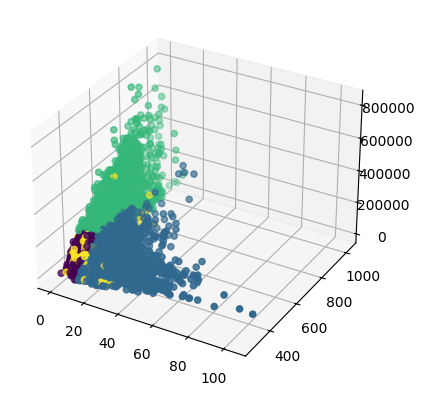

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x = np.array(df2["proton_density"])
y = np.array(df2["proton_speed"])
z = np.array(df2["proton_temp"])

ax.scatter(x, y, z, c=df2["Cluster"])
plt.show()

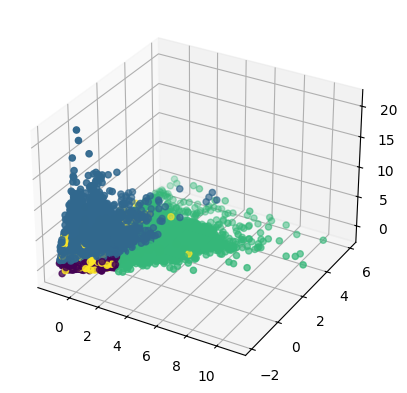

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

z = np.array(df3["proton_density"])
y = np.array(df3["proton_speed"])
x = np.array(df3["proton_temp"])

ax.scatter(x, y, z, c=df2["Cluster"])
plt.show()

In [24]:
def evaluate_PCA_components(features: list, X):
    from sklearn.decomposition import PCA

    pca = PCA()

    pca.fit(X)

    num_components = list(range(1, len(features) + 1))

    plt.figure(figsize=(10, 10))
    plt.plot(
        num_components,
        pca.explained_variance_ratio_.cumsum(),
        marker="o",
        linestyle="--",
    )
    plt.title("Variance Ratio by Number of Components")
    plt.xlabel("# of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(ls="--")

    return plt.show()

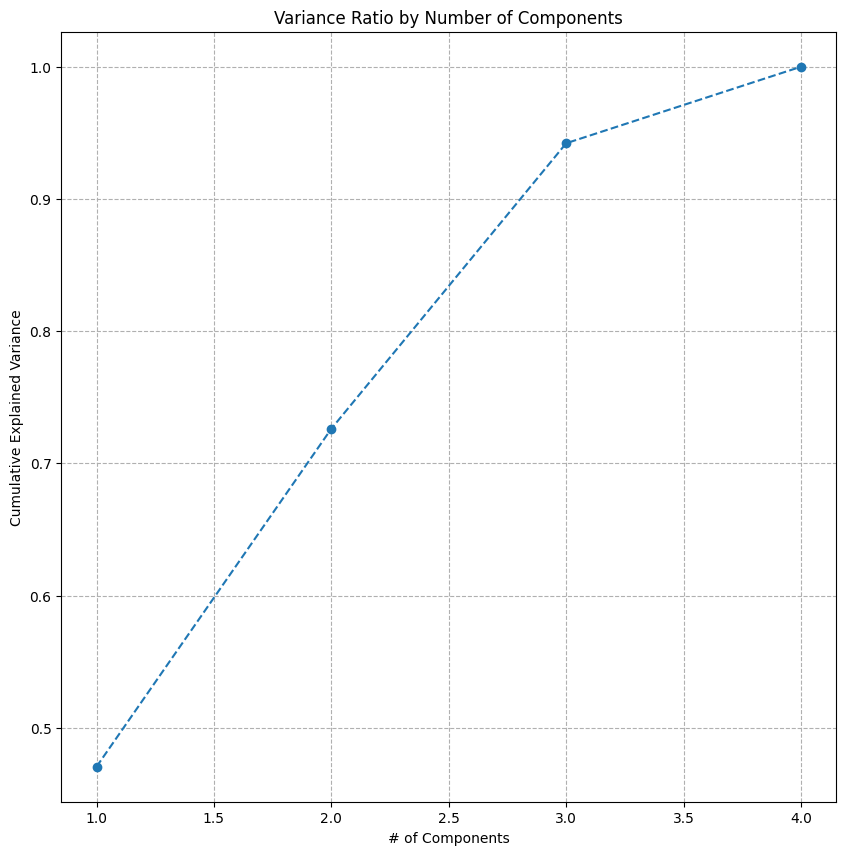

In [25]:
feats = df.columns.tolist()
evaluate_PCA_components(feats, scaled_df)

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_df)

pca_df = pca.transform(scaled_df)

kmeans_pca = KMeans(
    n_clusters=optimal_k, init="k-means++", max_iter=100, n_init=1, random_state=4
)

kmeans_pca.fit(pca_df)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=4)

In [28]:
print(
    metrics.calinski_harabasz_score(pca_df, kmeans_pca.labels_),
    davies_bouldin_score(pca_df, kmeans_pca.labels_),
)

86742.12451848904 0.9060390745368203


In [29]:
pca_df = pd.DataFrame(pca_df, columns=["PC1", "PC2"])
pca_df["Cluster"] = kmeans_pca.labels_
pca_df.head(10)

,PC1,PC2,Cluster
0,-2.488987,-1.529426,1
1,-2.818979,-1.740908,1
2,-2.625311,-1.846591,1
3,-2.613394,-1.992733,1
4,-3.401135,-2.631275,1
5,-3.028890,-2.238486,1
6,-3.349849,-2.360010,1
7,-3.525905,-2.199559,1
8,-3.685429,-2.609259,1
9,-3.619555,-2.232306,1


Text(0.5, 1.0, 'PCA Enhanced K-means Clusters')

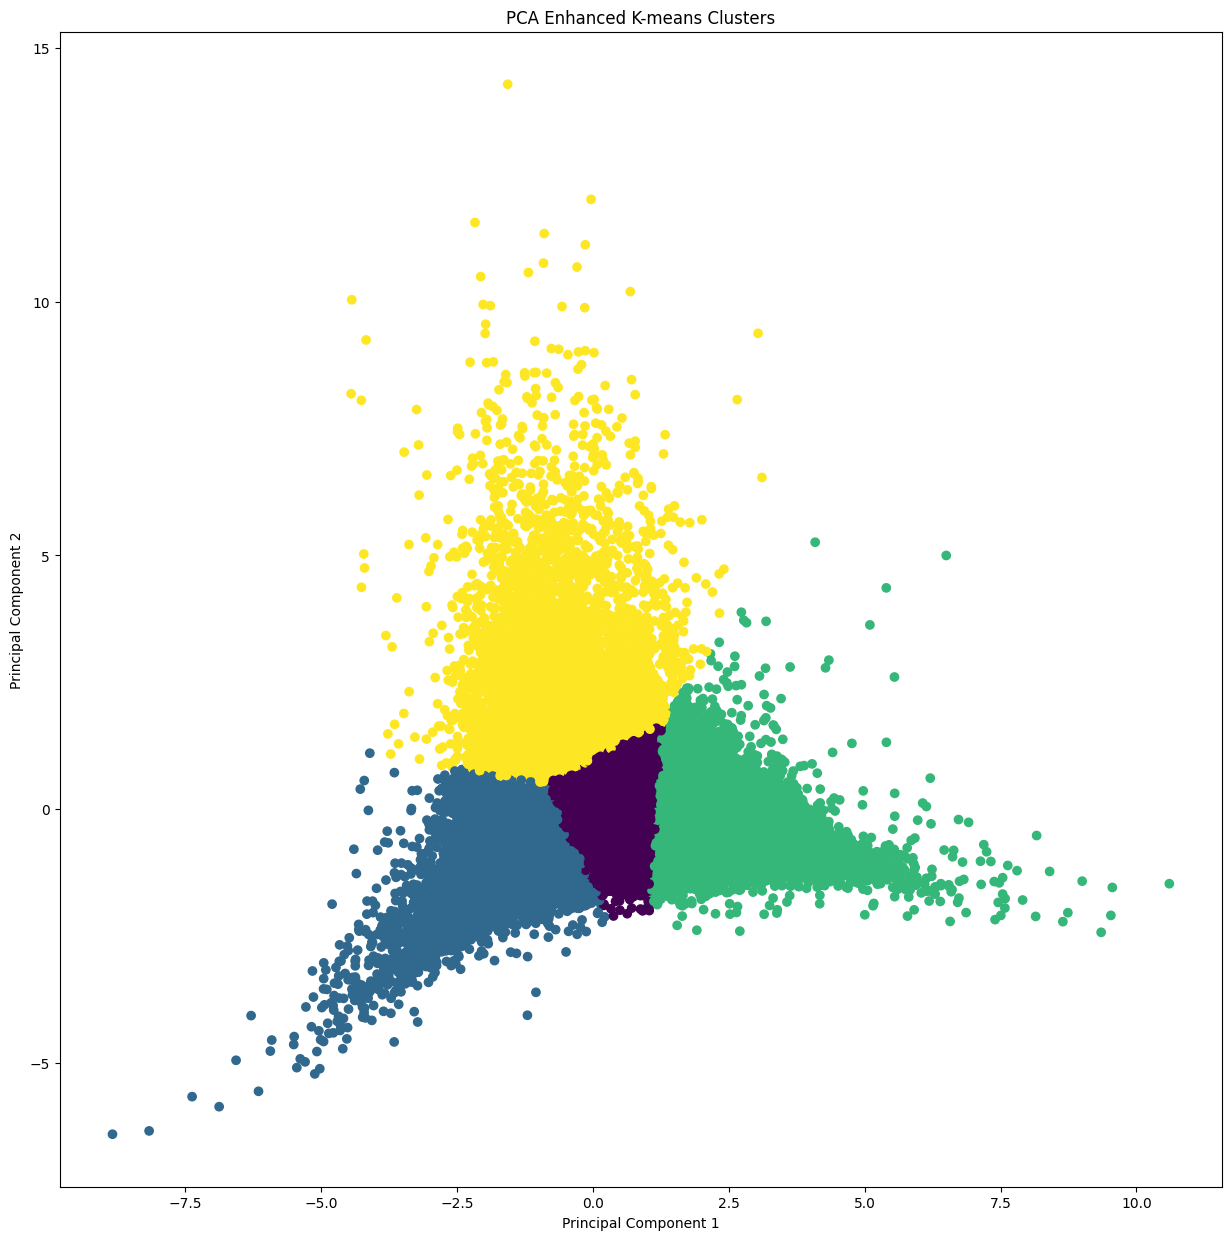

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"])
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA Enhanced K-means Clusters")

In [35]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [37]:
def DBSCAN_scoring(
    min_samples_lst: list, eps_lst: list, X: np.array, metric: str = "euclidean"
):
    eps = []
    min_samples = []
    sil_scores = []
    noise_lst = []
    noise = -1
    num_clusters = []
    db_scores = {}

    for amount in eps_lst:
        if min_samples_lst:
            for sample in min_samples_lst:
                eps.append(amount)
                min_samples.append(sample)
                db_model = DBSCAN(eps=amount, min_samples=sample, metric=metric)
                db_model.fit(X)

                clusters = db_model.labels_
                num_clusters.append(len(np.unique(clusters)))
                if len(np.unique(clusters)) > 1:
                    sil_scores.append(
                        silhouette_score(
                            X,
                            db_model.labels_,
                            random_state=random_state,
                            metric=metric,
                        )
                    )
                else:
                    sil_scores.append(None)
                noise_lst.append(len([i for i in clusters if i == noise]))

        else:
            eps.append(amount)
            min_samples.append(5)
            db_model = DBSCAN(eps=amount, min_samples=5, metric=metric)
            db_model.fit(X)
            clusters = db_model.labels_
            if len(np.unique(clusters)) > 1:
                sil_scores.append(
                    silhouette_score(
                        X, db_model.labels_, random_state=random_state, metric=metric
                    )
                )
            else:
                sil_scores.append(None)

            num_clusters.append(len(np.unique(clusters)))
            noise_lst.append(len([i for i in clusters if i == noise]))

    db_scores["epsilon"] = eps
    db_scores["min_samples"] = min_samples
    db_scores["silhouette_score"] = sil_scores
    db_scores["noise"] = noise_lst
    db_scores["#_clusters"] = num_clusters
    df = pd.DataFrame(db_scores)

    return df

In [38]:
eps_lst = np.arange(0.1, 1.1, 0.1).tolist()
db_score_df = DBSCAN_scoring(None, eps_lst, scaled_df)
db_score_df

,epsilon,min_samples,silhouette_score,noise,#_clusters
0,0.1,5,-0.715553,63138,1261
1,0.2,5,-0.508763,11842,220
2,0.3,5,-0.164443,4003,71
3,0.4,5,0.030648,1806,34
4,0.5,5,0.104635,986,20
5,0.6,5,0.343410,611,8
6,0.7,5,0.400938,387,7
7,0.8,5,0.406405,284,5
8,0.9,5,0.397320,190,7
9,1.0,5,0.721168,145,3
